## Regularization techniques

The goal of this notebook is to study the effect of applying different regularization techniques in a Polynomial Regression model. The idea is to increase the model complexity by increasing the degree of the polynomial and using Lasso, Ridge and Elastic Net methods to avoid overfitting.

For this exercise we will use the California housing dataset (target = 'median_house_value').

1- Uploading and cleaning data   
2- Designing a simple data pipeline to create dummy variables, change degree of polynomial and normalize  
3- Test the different regularization methods using GridSearch  
4- Test a more complex model (Random Forest)  
5- Conclusion  



In [1]:
import os
import tarfile
from six.moves import urllib
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.feature_selection import SelectKBest, chi2,f_classif, f_regression, mutual_info_classif
from sklearn.metrics import precision_recall_curve,roc_curve
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso,Ridge,ElasticNet
from sklearn.ensemble import RandomForestRegressor

import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()

In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


### Fix the categories in the categorical variable

In [4]:
d = {'<1H OCEAN':'LESS_1H_OCEAN', 'INLAND':'INLAND', 'ISLAND':'ISLAND', 'NEAR BAY':'NEAR_BAY', 'NEAR OCEAN':'NEAR_OCEAN'}
housing['ocean_proximity'] = housing['ocean_proximity'].map(lambda s: d[s])

### Add 2 more features

In [5]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["population_per_household"]=housing["population"]/housing["households"]

### Fix missing data

In [6]:
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True) 

### Create dummy variables based on the categorical variable

In [7]:
one_hot = pd.get_dummies(housing['ocean_proximity'])
housing = housing.drop('ocean_proximity', axis=1)
housing = housing.join(one_hot)

### Check the data

In [11]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 16 columns):
longitude                   20640 non-null float64
latitude                    20640 non-null float64
housing_median_age          20640 non-null float64
total_rooms                 20640 non-null float64
total_bedrooms              20640 non-null float64
population                  20640 non-null float64
households                  20640 non-null float64
median_income               20640 non-null float64
median_house_value          20640 non-null float64
rooms_per_household         20640 non-null float64
population_per_household    20640 non-null float64
INLAND                      20640 non-null uint8
ISLAND                      20640 non-null uint8
LESS_1H_OCEAN               20640 non-null uint8
NEAR_BAY                    20640 non-null uint8
NEAR_OCEAN                  20640 non-null uint8
dtypes: float64(11), uint8(5)
memory usage: 1.8 MB


### 1.1 Partition into train and test

Use `train_test_split` from `sklearn.model_selection` to partition the dataset into 70% for training and 30% for testing.

You can use the 70% for training set as both training and validation by using cross-validation.


In [9]:
from sklearn.model_selection import train_test_split
target_col = 'median_house_value'


X = housing.drop([target_col], axis = 1)
y = housing[target_col]

X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.2, random_state = 123)

In [14]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4128 entries, 19121 to 18254
Data columns (total 15 columns):
longitude                   4128 non-null float64
latitude                    4128 non-null float64
housing_median_age          4128 non-null float64
total_rooms                 4128 non-null float64
total_bedrooms              4128 non-null float64
population                  4128 non-null float64
households                  4128 non-null float64
median_income               4128 non-null float64
rooms_per_household         4128 non-null float64
population_per_household    4128 non-null float64
INLAND                      4128 non-null uint8
ISLAND                      4128 non-null uint8
LESS_1H_OCEAN               4128 non-null uint8
NEAR_BAY                    4128 non-null uint8
NEAR_OCEAN                  4128 non-null uint8
dtypes: float64(10), uint8(5)
memory usage: 374.9 KB


### 1.2 Polynomial transformations

In [16]:
y_test.mean()

206404.1664244186

Use PolynomialFeatures from sklearn.preprocessing

In [20]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=True)
X_tr = poly_features.fit_transform(X_train)

features = X_train.columns

In [21]:
print("Original number of features: "+str(len(features)))
print("Final number of features: "+str(X_tr.shape[1]))

Original number of features: 15
Final number of features: 136


### 1.3 Scaling features

Similarly, use `StandardScaler` from `sklearn.preprocessing` to normalize the training and testing data, using the training data

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_tr_st = scaler.fit_transform(X_tr)

#### Comparing models

Use this function to display your cross val scores, or you may use your own custom function.

**Either way it is important to display your results as you train new models.**

In [24]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())

### 1.4 Data Pipeline 

In [34]:
# Data Pipeline for the polynomial transformer and standard scaler processes

prep_pipeline = Pipeline([
        ('polynomial_transformer', PolynomialFeatures(degree=2, include_bias=False)),
        ('scaler', StandardScaler()),
    ])

### 2.1 Linear regression on original features (no transformations) --- benchmark

Train a simple linear regression model using `cross_val_score` with no regularization or feature transformations. This model will serve as your benchmark.

#### 2.1.1 Linear regression SciKit

In [31]:
X_train_mod1 =  scaler.fit_transform(X_train)

reg = LinearRegression()

display_scores(cross_val_score(reg, X_train_mod1, y_train, cv=5, scoring = 'neg_mean_squared_error'))

Scores: [-4.56142091e+09 -4.72836524e+09 -4.82082692e+09 -4.78076718e+09
 -4.81602773e+09]
Mean: -4741481595.184526
Standard Deviation: 95906258.0276629


In [32]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted'])

### 2.2 Linear regression  (on transformed features: polynomial transformation + scaling)

Now do as in **2.1** but with the original and transformed features (136 features)

In [36]:

X_train_mod2 = prep_pipeline.fit_transform(X_train)

display_scores(cross_val_score(reg, X_train_mod2, y_train, cv=3, scoring = 'neg_mean_squared_error'))

Scores: [-3.47620692e+29 -3.85891621e+09 -4.76765843e+24]
Mean: -1.1587515324761284e+29
Standard Deviation: 1.638688420327861e+29


If the error on the cross-validation is too high it is because the model is over-fitting. Regularization is needed.

### 2.3 Ridge regression

Using the same transformed dataset from **2.2**, train another linear model but this time apply L2 regularization. Run the model through grid search to find the optimal regularization hyperparams. Print the results. 

In [18]:
np.arange(1,700,50)

array([  1,  51, 101, 151, 201, 251, 301, 351, 401, 451, 501, 551, 601,
       651])

In [19]:
param_grid = [{'Ridge_reg__alpha': np.arange(400,700,50)}]

full_pipeline_predictor = Pipeline([
        ("preparation", prep_pipeline),
        ("Ridge_reg", Ridge())
    ])

ridge_grid_search = GridSearchCV(full_pipeline_predictor, param_grid, cv=5,
                           scoring = 'neg_root_mean_squared_error', return_train_score=True)

ridge_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preparation',
                                        Pipeline(memory=None,
                                                 steps=[('polynomial_transformer',
                                                         PolynomialFeatures(degree=2,
                                                                            include_bias=False,
                                                                            interaction_only=False,
                                                                            order='C')),
                                                        ('scaler',
                                                         StandardScaler(copy=True,
                                                                        with_mean=True,
                                                                        with_std=True))],
                    

In [20]:
ridge_grid_search.best_params_

{'Ridge_reg__alpha': 450}

In [21]:
ridge_grid_search.best_score_

-71361.76121948808

In [22]:
display_scores(cross_val_score(ridge_grid_search, X_train, y_train, cv=5, scoring = 'neg_root_mean_squared_error'))

Scores: [ -64998.68408651  -65992.66374544  -66223.64387646  -65935.67384834
 -127585.52904961]
Mean: -78147.23892127315
Standard Deviation: 24722.690642746456


### 2.4 Lasso regression

Now do the same as in **2.3** but with Lasso

In [23]:
param_grid = [{'Lasso_reg__alpha': np.arange(1,700,50)}]

full_pipeline_predictor = Pipeline([
        ("preparation", prep_pipeline),
        ("Lasso_reg", Lasso())
    ])

lasso_grid_search = GridSearchCV(full_pipeline_predictor, param_grid, cv=5, 
                           scoring = 'neg_root_mean_squared_error', return_train_score=True)

lasso_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preparation',
                                        Pipeline(memory=None,
                                                 steps=[('polynomial_transformer',
                                                         PolynomialFeatures(degree=2,
                                                                            include_bias=False,
                                                                            interaction_only=False,
                                                                            order='C')),
                                                        ('scaler',
                                                         StandardScaler(copy=True,
                                                                        with_mean=True,
                                                                        with_std=True))],
                    

In [24]:
lasso_grid_search.best_params_

{'Lasso_reg__alpha': 651}

In [25]:
lasso_grid_search.best_score_

-70982.07183120243

In [26]:
display_scores(cross_val_score(lasso_grid_search, X_train, y_train, cv=5, scoring = 'neg_root_mean_squared_error'))

Scores: [  -68457.02039674   -66513.75860289   -66631.24645763   -64207.52886099
 -4548069.28216259]
Mean: -962775.767296169
Standard Deviation: 1792647.2647110103


### 2.5 Elastic Net regression

Do the same as in **2.3** and **2.4**, but now with Elastic Net. However, the grid search should be over the parameters alpha and  L1 ratio. Use just 3 values for L1 ratio.

In [27]:
param_grid = [{'ElasticNet_reg__l1_ratio': np.arange(0,1,0.05)}]

full_pipeline_predictor = Pipeline([
        ("preparation", prep_pipeline),
        ("ElasticNet_reg", ElasticNet())
    ])

ENR_grid_search = GridSearchCV(full_pipeline_predictor, param_grid, cv=5, 
                           scoring = 'neg_root_mean_squared_error', return_train_score=True)

ENR_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preparation',
                                        Pipeline(memory=None,
                                                 steps=[('polynomial_transformer',
                                                         PolynomialFeatures(degree=2,
                                                                            include_bias=False,
                                                                            interaction_only=False,
                                                                            order='C')),
                                                        ('scaler',
                                                         StandardScaler(copy=True,
                                                                        with_mean=True,
                                                                        with_std=True))],
                    

In [28]:
ENR_grid_search.best_params_

{'ElasticNet_reg__l1_ratio': 0.9500000000000001}

In [29]:
ENR_grid_search.best_score_

-78647.94449692321

In [30]:
display_scores(cross_val_score(ENR_grid_search, X_train, y_train, cv=5, scoring = 'neg_root_mean_squared_error'))

Scores: [ -69542.45442077  -69455.82910268  -70804.6225084   -70905.8785971
 -140238.2967045 ]
Mean: -84189.4162666908
Standard Deviation: 28031.033364251514


### 3.1  Expected Results

Before you compute the final_rmse on the test data using your best model, pause and reflect:
- Does your best model have high variance? 
- Why was your best performing model better than the others?
- What is your expected rmse score on your test data? 

Out of the four models tested the linear regression with no polynomial transformation performed better (benchmark model).The mean squared error and cross validation standard variation displayed the lowest values, 68.854 and 699 respectively. It is worth noting the very small variance obtained. This suggests that this particular model generalizes very well with a reasonable error ,even though it is a fairly simple one.

The polynomial transformation added a lot more complexity to the models to the point that it overfitted given that no regularization was applied. Interestingly the regularization was not able to reduce the variability of the models to the extent it would surpass the performance of our simple benchmark model. Note that Ridge and Lasso regression displayed reasonable square mean error but the cross validation standard deviation. One factor that is important to take into consideration is the immense number of features acquired after the polynomial transformation (from 15 to 135 features), not only exceeded the complexity of the model but also caused converge issues on both Lasso and Elastic Net regression.

The expected rmse score for the test data should be close to the value obtained for the cross validation score for the chosen model.


### 3.2. Evaluating your best model on TESTING data

Of the models you created above, choose the best one to test on the test set.

In [31]:
from sklearn.metrics import mean_squared_error

X_train_mod1 =  scaler.fit_transform(X_train)
X_test_mod1 =  scaler.fit_transform(X_test)

reg.fit(X_train_mod1, y_train)

y_pred = reg.predict(X_test_mod1) 

final_mse = mean_squared_error(y_test, y_pred) # swap 'YOUR_PREDICTIONS' with the predictions values your model produces
final_rmse = np.sqrt(final_mse)
print(final_rmse)

68406.01279745529


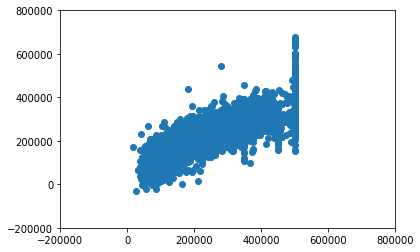

In [32]:
# Plot the results
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred) # swap 'YOUR_PREDICTIONS' with the prediction values your model produces
plt.xlim([-200000,800000])
plt.ylim([-200000,800000])
plt.show()

### 4.1 Try a more advanced model

### Random Forest model

In [33]:

param_grid = [{'Random_forest_reg__max_depth': np.arange(2,10,2)}]

full_pipeline_predictor = Pipeline([
        ("preparation", prep_pipeline),
        ("Random_forest_reg", RandomForestRegressor(random_state=42, n_estimators =100))
    ])

rfreg_grid_search = GridSearchCV(full_pipeline_predictor, param_grid, cv=5,
                           scoring = 'neg_root_mean_squared_error', return_train_score=True)

rfreg_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preparation',
                                        Pipeline(memory=None,
                                                 steps=[('polynomial_transformer',
                                                         PolynomialFeatures(degree=2,
                                                                            include_bias=False,
                                                                            interaction_only=False,
                                                                            order='C')),
                                                        ('scaler',
                                                         StandardScaler(copy=True,
                                                                        with_mean=True,
                                                                        with_std=True))],
                    

In [34]:
rfreg_grid_search.best_params_

{'Random_forest_reg__max_depth': 8}

In [35]:
rfreg_grid_search.best_score_

-55563.15440257113

In [44]:
start = time.time()
display_scores(cross_val_score(rfreg_grid_search, X_train, y_train, cv=5, scoring = 'neg_root_mean_squared_error'))
print (time.time()- start)

Scores: [-53467.92382251 -55161.10448251 -55416.68197657 -56705.65705882
 -57064.40467244]
Mean: -55563.15440257113
Standard Deviation: 1275.31597541294
2277.3952929973602


In [45]:
start = time.time()

x_train_mod2 = prep_pipeline.fit_transform(X_train)
display_scores(cross_val_score(RandomForestRegressor(random_state=42, n_estimators =100,max_depth=  8 ), x_train_mod2, y_train, cv=5, scoring = 'neg_root_mean_squared_error'))

print (time.time()- start)

Scores: [-53467.14198101 -55164.44995252 -55419.37810121 -56698.33620197
 -57067.07188905]
Mean: -55563.27562515088
Standard Deviation: 1274.6223272018574
198.57852911949158


The random forest model algorithm consists of many decisions trees. It uses bagging and feature randomness when building each individual tree to try to create an uncorrelated forest of trees whose prediction by committee is more accurate than that of any individual tree. Therefore due to the nature of this algorithm it's expected to perform better than linear models.